## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

The notebook is broken down to these separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Creating a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Using a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Creating a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Writing an Algorithm
* [Step 7](#step7): Testing the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

root_path = "/Users/*"
# load train, test, and validation datasets
train_files, train_targets = load_dataset(root_path+'dogImages/train')
valid_files, valid_targets = load_dataset(root_path+'/dogImages/valid')
test_files, test_targets = load_dataset(root_path+'/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
dog_breeds=len(dog_names)

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob(root_path+"lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

Here, OpenCV's implementation of [Haar feature-based cascade classifiers] (http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is used to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors is downloaded and stored in the `haarcascades` directory.

Number of faces detected: 1


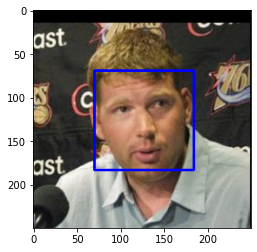

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[13])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
h_as_h_count=0
d_as_h_count=0

for img in human_files_short:
    is_human=face_detector(img)
    if is_human:
        h_as_h_count += 1
        percent=h_as_h_count*100/len(human_files_short)
print('Percentage of human faces detected: {}%'.format(percent))

for img in dog_files_short:
    is_human=face_detector(img)
    if is_human:
        d_as_h_count += 1
        percent=d_as_h_count*100/len(dog_files_short)
print('Percentage of human faces wrongly detected: {}%'.format(percent))

Percentage of human faces detected: 100.0%
Percentage of human faces wrongly detected: 12.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

2022-02-27 18:54:47.398323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 18:54:47.398722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
102981632/102967424 [==============================] - 13s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 


The dog detector performs very well with images of dogs with an __accuracy of 100%__, whereas it detects __11% of human faces as dogs__ from the human files dataset.

In [12]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

h_as_d_count=0
d_as_d_count=0
for img in human_files_short:
    is_dog=dog_detector(img)
    if is_dog:
        h_as_d_count += 1
        percent=h_as_d_count*100/len(human_files_short)
print('Percentage of dog faces wrongly detected: {}%'.format(percent))

for img in dog_files_short:
    is_dog=dog_detector(img)
    if is_dog:
        d_as_d_count += 1
        percent=d_as_d_count*100/len(dog_files_short)
print('Percentage of dog faces detected: {}%'.format(percent))

2022-02-27 18:56:13.069319: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-27 18:56:13.357590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percentage of dog faces wrongly detected: 12.0%
Percentage of dog faces detected: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:03<00:00, 219.54it/s]


In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

###  Define the architecture.

model.add(Conv2D(filters=16, kernel_size=(2,2), padding='valid', input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), padding='valid'))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), padding='valid'))
model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.2))
model.add(Dense(dog_breeds, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We can use model checkpointing to save the model that attains the best validation loss.
Training data can also be augmented to increase the size of the training set.

In [16]:
from keras.callbacks import ModelCheckpoint  

### Specify the number of epochs that you would like to use to train the model.

epochs = 5


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5


2022-02-27 18:58:09.272345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


333/334 [============================>.] - ETA: 0s - loss: 4.8723 - accuracy: 0.0105

2022-02-27 18:58:23.420674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 4.83159, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 15s 34ms/step - loss: 4.8722 - accuracy: 0.0105 - val_loss: 4.8316 - val_accuracy: 0.0180
Epoch 2/5
334/334 [==============================] - ETA: 0s - loss: 4.7654 - accuracy: 0.0172
Epoch 00002: val_loss improved from 4.83159 to 4.73320, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 11s 32ms/step - loss: 4.7654 - accuracy: 0.0172 - val_loss: 4.7332 - val_accuracy: 0.0228
Epoch 3/5
333/334 [============================>.] - ETA: 0s - loss: 4.6671 - accuracy: 0.0287
Epoch 00003: val_loss improved from 4.73320 to 4.66354, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 10s 30ms/step - loss: 4.6671 - accuracy: 0.0286 - val_loss: 4.6635 - val_accuracy: 0.0299
Epoch 4/5
333/334 [============================>.] - ETA: 0s - los

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

The accuracy for this basic model should be at least 1/133 ~ 1%, that is even by predicting the same breed for every image, we can get one right.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

2022-02-27 18:59:30.301192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 5.1435%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we can use transfer learning.  

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load(root_path+'bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
#VGG16_model.add()
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=25, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/25


2022-02-27 19:05:24.408856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


332/334 [============================>.] - ETA: 0s - loss: 8.0504 - accuracy: 0.2297

2022-02-27 19:05:27.056438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 3.68821, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 3s 8ms/step - loss: 8.0220 - accuracy: 0.2308 - val_loss: 3.6882 - val_accuracy: 0.4228
Epoch 2/25
329/334 [============================>.] - ETA: 0s - loss: 2.2304 - accuracy: 0.5933
Epoch 00002: val_loss improved from 3.68821 to 2.50280, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 2s 7ms/step - loss: 2.2287 - accuracy: 0.5940 - val_loss: 2.5028 - val_accuracy: 0.5473
Epoch 3/25
329/334 [============================>.] - ETA: 0s - loss: 1.2411 - accuracy: 0.7363
Epoch 00003: val_loss improved from 2.50280 to 1.99486, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 3s 8ms/step - loss: 1.2386 - accuracy: 0.7376 - val_loss: 1.9949 - val_accuracy: 0.6096
Epoch 4/25
333/334 [============================>.] - ETA: 0s - loss: 0.7968 - accuracy: 0.

### Load the Model with the Best Validation Loss

In [26]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  The test accuracy is printed below.

In [27]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

2022-02-27 19:06:30.777381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 69.4976%


### Predict Dog Breed with the Model

In [28]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.
In this section, we shall use the bottleneck features from a different pre-trained model.  Below are pre computed features for all networks, that can be downloaded to any local machine.
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



In [30]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load(root_path+'bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

###  Model Architecture

Create a CNN to classify dog breed.  For this part, I had experimented with VGG, Resnet50, Inception and Xception arcihtectures. Each architecture was simply connected to a global average pooling layer which would flatten the array to a vector before being passed on to a dense output layer. 

Following were the results for each model

Inception: The number of parameters were 272,517 and the accuracy was around 81%

Resnet50: The number of parameters were 272,517 and the accuracy was around 80%

VGG19: The number of parameters were 68,229 and the accuracy was around 45%

Xception: The number of parameters were 272,517 and the accuracy was around 85%

I found that the Xception architecture yielded the highest accuracy for this problem.


In [31]:
### TODO: Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
#Xception_model.add()
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


###  Compile the Model

In [33]:
### Compile the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

Model checkpointing can be used to save the model that attains the best validation loss.  

We can also [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to increase the size of the training set. 

In [34]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20


2022-02-27 19:29:14.264466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


333/334 [============================>.] - ETA: 0s - loss: 1.1131 - accuracy: 0.7336

2022-02-27 19:29:17.618250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.55378, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 4s 10ms/step - loss: 1.1107 - accuracy: 0.7343 - val_loss: 0.5538 - val_accuracy: 0.8204
Epoch 2/20
332/334 [============================>.] - ETA: 0s - loss: 0.3490 - accuracy: 0.8950
Epoch 00002: val_loss improved from 0.55378 to 0.51104, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 3s 9ms/step - loss: 0.3496 - accuracy: 0.8946 - val_loss: 0.5110 - val_accuracy: 0.8335
Epoch 3/20
328/334 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9337
Epoch 00003: val_loss improved from 0.51104 to 0.49707, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 3s 9ms/step - loss: 0.2269 - accuracy: 0.9337 - val_loss: 0.4971 - val_accuracy: 0.8443
Epoch 4/20
330/334 [============================>.] - ETA: 0s - loss: 0.1561 - ac

###  Load the Model with the Best Validation Loss

In [35]:
### Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the Model

In [36]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

2022-02-27 19:35:12.974123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 84.4498%


### Predict Dog Breed with the Model

To predict a breed, we can write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.  


The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to the chosen CNN architecture, we need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [37]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Xception_breed_pred(img_path):
    bottle_neck_feature=extract_Xception(path_to_tensor(img_path))
    predicted_vector=Xception_model.predict(bottle_neck_feature)
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write the Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.




In [38]:
def display_image(img_path):
    img=cv2.imread(img_path)
    cv_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_plot=plt.imshow(cv_rgb)
    return img_plot

def breed_pred(img_path):
    
    display_image(img_path)
        
    if dog_detector(img_path):
        print('Ding! It\'s a dog!')
        return print("This dog looks like a member of the {} species". format(Xception_breed_pred(img_path)))
    
    if face_detector(img_path):
        print("Bonk! That's a human!")
        return print ('If this person were a dog they would probably be a member of the {} species'.format(Xception_breed_pred(img_path)))
    
    else:
        return print("Boing! That's neither dog nor human.")

---
<a id='step7'></a>
## Step 7: Test the Algorithm


For an accuracy around 85%, the output was not much different from what I expected. It correctly recognised almost all the sample photos of dogs that I had tested the model on. It even correctly recognised a cartoon picture of a Dalmatian. It performed pretty well on human detection as well. However it failed on one of the dog sample pictures.

I think the accuracy of the model could be further increased by
1. Having more data on the training set
2. Performing data augmentation where images may be scaled, translated and rotated, as well as varying brightness and clarity of picture. This process increases the dataset without increasing the actual number of input images. This means with any given data, we can still do a lot more.
3. Modify the architecture of the model and find a balance between overfitting and finding more patterns.
4. Increasing the depth of the neural networks also increases the number of patterns that are identified.

In [39]:
## Testing the algorithm

test_samples=np.array(glob("TestSamples/*"))
print(test_samples)


['TestSamples/Test13.jpg' 'TestSamples/Test12.jpg' 'TestSamples/Test6.jpg'
 'TestSamples/Test7.jpg' 'TestSamples/Test5.jpg' 'TestSamples/Test4.jpg'
 'TestSamples/Test1.jpg' 'TestSamples/Test3.jpg' 'TestSamples/Test2.jpg'
 'TestSamples/Test9.jpg' 'TestSamples/Test8.jpg']


Ding! It's a dog!
83697664/83683744 [==============================] - 11s 0us/step


2022-02-27 19:37:51.187852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This dog looks like a member of the Pomeranian species


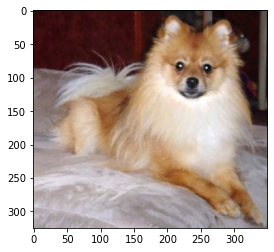

In [40]:
breed_pred('TestSamples/Test12.jpg')


Ding! It's a dog!


2022-02-27 19:38:04.153013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This dog looks like a member of the Dalmatian species


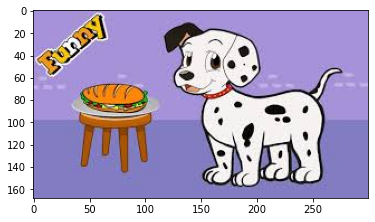

In [41]:
breed_pred('TestSamples/Test5.jpg')


Ding! It's a dog!


2022-02-27 20:18:53.175278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This dog looks like a member of the Basenji species


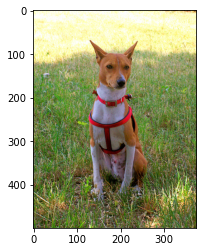

In [49]:
breed_pred('TestSamples/Test3.jpg')


Bonk! That's a human!


2022-02-27 19:38:09.953537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


If this person were a dog they would probably be a member of the Pekingese species


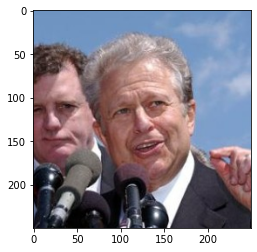

In [43]:
breed_pred('TestSamples/Test9.jpg')

Ding! It's a dog!


2022-02-27 20:19:11.006400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This dog looks like a member of the Beagle species


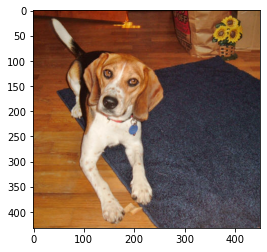

In [50]:
breed_pred('TestSamples/Test4.jpg')

Boing! That's neither dog nor human.


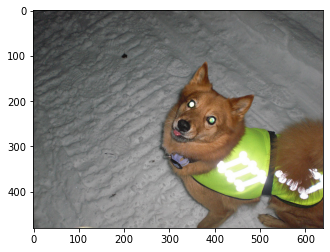

In [45]:
breed_pred('TestSamples/Test6.jpg')

Boing! That's neither dog nor human.


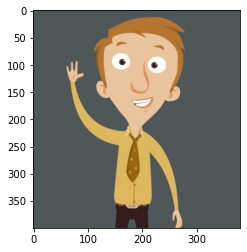

In [46]:
breed_pred('TestSamples/Test8.jpg')

Ding! It's a dog!


2022-02-27 19:38:29.389397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This dog looks like a member of the German_shepherd_dog species


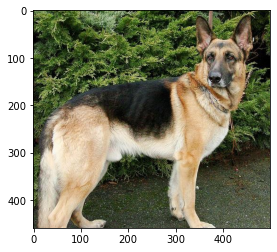

In [47]:
breed_pred('TestSamples/Test7.jpg')